# IBM Applied Data Science Capstone
### Opening New Restaurant in New York, US
* Build a dataframe of neighborhoods of New York by we scraping the data from NYU page
* Get geographical coordinates of the neighboerhoods
* Obtain the venue data for neighborhoods from FourSquare
* Explore and cluster the neighborhoods
* Select the best cluster to open a new restaurant

## 1. Import required libraries

In [146]:
import numpy as np
import pandas as pd
import json
import requests
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

## 2. Scrap data from NYU into a dataframe

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
location_data = newyork_data['features']
neighborhood = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in location_data:
    bor = n_name = data['properties']['borough']
    n_name = data['properties']['name']
    lat_lon = data['geometry']['coordinates']
    neighborhood = neighborhood.append({'Borough' : bor,
                                        'Neighborhood' : n_name,
                                        'Latitude' : lat_lon[1],
                                        'Longitude' : lat_lon[0]
                                       }, ignore_index = True)
neighborhood.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [3]:
print("New York has {} boroughs and {} neighborhoods".format(len(neighborhood['Borough'].unique()),neighborhood.shape[0]))

New York has 5 boroughs and 306 neighborhoods


## 3. Create a map of New York with its neighborhoods marked

In [4]:
locator = Nominatim(user_agent="ny_explorer")
location = locator.geocode("New York City, NY")
map_newyork = folium.Map(location=[location.latitude,location.longitude],zoom_start = 10)
for lat,long,bor,neigh in zip(neighborhood['Latitude'],neighborhood['Longitude'],neighborhood['Borough'],neighborhood['Neighborhood']):
    label = '{}, {}'.format(neigh,bor)
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker(
        [lat,long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = "#3186cc",
        fill_opacity = 0.6
    ).add_to(map_newyork)
    
map_newyork

In [5]:
# The code was removed by Watson Studio for sharing.

## 4. Getting nearby venues using FourSquare API

In [7]:
new_york_venue = pd.DataFrame(columns = ['Borough','Neighborhood','Latitude','Longitude','Venue','Venue Latitude','Venue Longitude','Category'])
for lat,long,bor,neigh in zip(neighborhood['Latitude'],neighborhood['Longitude'],neighborhood['Borough'],neighborhood['Neighborhood']):
    print("{} - {} - {}, {}".format(bor,neigh,lat,long))
    url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(client_id,client_secret,version,lat,long,rad,lim)
    result = requests.get(url).json()["response"]['groups'][0]['items']
    for v in result:
        new_york_venue = new_york_venue.append({'Borough' : bor,
                                                'Neighborhood' : neigh,
                                                'Latitude' : lat,
                                                'Longitude' : long,
                                                'Venue' : v['venue']['name'],
                                                'Venue Latitude' : v['venue']['location']['lat'],
                                                'Venue Longitude' : v['venue']['location']['lng'],
                                                'Category' : v['venue']['categories'][0]['name']
                                               }, ignore_index = True)
        
new_york_venue.head()

,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


## 5. Preparing data for cluster analysis

In [102]:
dummy_df = pd.get_dummies(new_york_venue[['Category']],prefix="",prefix_sep="")
dummy_df['Borough'] = new_york_venue['Borough']
dummy_df['Neighbourhood'] = new_york_venue['Neighborhood']
dummy_df['Latitude'] = new_york_venue['Latitude']
dummy_df['Longitude'] = new_york_venue['Longitude']
col = list(dummy_df.columns[-4:]) + list(dummy_df.columns[:-4])
dummy_df = dummy_df[col]
dummy_df.head()

,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bronx,Wakefield,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
ny_grouped = dummy_df.groupby(['Borough','Neighbourhood','Latitude','Longitude']).mean().reset_index()
ny_grouped.head()

,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bronx,Allerton,40.865788,-73.859319,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Bronx,Baychester,40.866858,-73.835798,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Bronx,Bedford Park,40.870185,-73.885512,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Bronx,Belmont,40.857277,-73.888452,0.0,0.0,0.0,0.0,0.0,0.010526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010526,0.0,0.0
4,Bronx,Bronxdale,40.852723,-73.861726,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## 6. Top ten venues of each neighborhood

In [198]:
num_top_venues = 10
indicators = ['st','nd','rd']
col = ['Borough','Neighborhood','Latitude','Longitude']
for ind in np.arange(num_top_venues):
    try:
        col.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        col.append('{}th Most Common Venue'.format(ind+1))
ny_venue_sorted = pd.DataFrame(columns=col)
ny_venue_sorted['Borough'] = ny_grouped['Borough']
ny_venue_sorted['Neighborhood'] = ny_grouped['Neighbourhood']
ny_venue_sorted['Latitude'] = ny_grouped['Latitude']
ny_venue_sorted['Longitude'] = ny_grouped['Longitude']
for ind in np.arange(ny_grouped.shape[0]):
    categories = ny_grouped.iloc[ind,4:]
    categories_sorted = categories.sort_values(ascending = False)
    ny_venue_sorted.iloc[ind,4:] = categories_sorted.index.values[0:num_top_venues]
ny_venue_sorted.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,40.865788,-73.859319,Pizza Place,Deli / Bodega,Supermarket,Intersection,Fast Food Restaurant,Grocery Store,Gas Station,Breakfast Spot,Bus Station,Spanish Restaurant
1,Bronx,Baychester,40.866858,-73.835798,Donut Shop,Mexican Restaurant,Arcade,Pet Store,Bank,Pizza Place,Electronics Store,Discount Store,Fast Food Restaurant,Sandwich Place
2,Bronx,Bedford Park,40.870185,-73.885512,Chinese Restaurant,Diner,Mexican Restaurant,Supermarket,Pizza Place,Sandwich Place,Pharmacy,Fried Chicken Joint,Deli / Bodega,Smoke Shop
3,Bronx,Belmont,40.857277,-73.888452,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Bank,Donut Shop,Fried Chicken Joint,Coffee Shop,Sandwich Place
4,Bronx,Bronxdale,40.852723,-73.861726,Chinese Restaurant,Supermarket,Park,Eastern European Restaurant,Pizza Place,Mexican Restaurant,Breakfast Spot,Bank,Spanish Restaurant,Gym


## 7. Performing cluster analysis

In [199]:
kcluster = 7
ny_clustering = ny_grouped.drop(["Borough","Neighbourhood","Latitude","Longitude"], 1)
kmeans = KMeans(n_clusters=kcluster, random_state=0).fit(ny_clustering)
ny_venue_sorted.insert(4,'Cluster Label',kmeans.labels_ + 1)
ny_venue_sorted.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,40.865788,-73.859319,3,Pizza Place,Deli / Bodega,Supermarket,Intersection,Fast Food Restaurant,Grocery Store,Gas Station,Breakfast Spot,Bus Station,Spanish Restaurant
1,Bronx,Baychester,40.866858,-73.835798,5,Donut Shop,Mexican Restaurant,Arcade,Pet Store,Bank,Pizza Place,Electronics Store,Discount Store,Fast Food Restaurant,Sandwich Place
2,Bronx,Bedford Park,40.870185,-73.885512,5,Chinese Restaurant,Diner,Mexican Restaurant,Supermarket,Pizza Place,Sandwich Place,Pharmacy,Fried Chicken Joint,Deli / Bodega,Smoke Shop
3,Bronx,Belmont,40.857277,-73.888452,3,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Bank,Donut Shop,Fried Chicken Joint,Coffee Shop,Sandwich Place
4,Bronx,Bronxdale,40.852723,-73.861726,4,Chinese Restaurant,Supermarket,Park,Eastern European Restaurant,Pizza Place,Mexican Restaurant,Breakfast Spot,Bank,Spanish Restaurant,Gym


## 8. Mapping obtained cluster on New York map

In [189]:
map_clusters = folium.Map(location=[lat,long], zoom_start=10)
x = np.arange(kcluster)
ys = [i+x+(i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat,lon,bor,poi,cluster in zip(ny_venue_sorted['Latitude'],ny_venue_sorted['Longitude'],ny_venue_sorted['Borough'],ny_venue_sorted['Neighborhood'],ny_venue_sorted['Cluster Label']):
    label = folium.Popup('{} : {} - Cluster {}'.format(bor, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)      
map_clusters

## 9. Further Analysis of various clusters

### 9.(i) Cluster 1 :-

In [200]:
cluster_1 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 1]
cluster_1.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
168,Queens,Bayswater,40.611322,-73.765968,1,Construction & Landscaping,Playground,Yoga Studio,Film Studio,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
245,Staten Island,Arlington,40.635325,-74.165104,1,Bus Stop,Playground,Home Service,Intersection,American Restaurant,Deli / Bodega,Boat or Ferry,Fast Food Restaurant,Filipino Restaurant,Field
248,Staten Island,Bloomfield,40.605779,-74.187256,1,Recreation Center,Burger Joint,Theme Park,Bus Stop,Film Studio,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
260,Staten Island,Emerson Hill,40.606794,-74.097762,1,Historic Site,Construction & Landscaping,Yoga Studio,Film Studio,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
261,Staten Island,Fox Hills,40.617311,-74.081740,1,Bus Stop,Sandwich Place,Yoga Studio,Financial or Legal Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market


#### Cluster 1 covers few neighborhoods of Staten Island and Queens. These areas contain bus stops, playgrounds, studios, cafes and hotels which contribute to favourable conditions for opening a restaurant. Some of the locations also have factories and cunstruction site nearby which should be strictly avoided.

### 9.(ii) Cluster 2 :-

In [201]:
cluster_2 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 2]
cluster_2.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
177,Queens,Brookville,40.660003,-73.751753,2,Deli / Bodega,Yoga Studio,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
240,Queens,Whitestone,40.781291,-73.814202,2,Bubble Tea Shop,Dance Studio,Deli / Bodega,Candy Store,Yoga Studio,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market
267,Staten Island,Grymes Hill,40.624185,-74.087248,2,Deli / Bodega,Dog Run,Yoga Studio,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
272,Staten Island,Mariner's Harbor,40.632546,-74.150085,2,Italian Restaurant,Deli / Bodega,Supermarket,Athletics & Sports,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
293,Staten Island,South Beach,40.580247,-74.079553,2,Deli / Bodega,Pier,Beach,Athletics & Sports,Yoga Studio,Financial or Legal Service,Exhibit,Factory,Falafel Restaurant,Farm


#### Cluster 2 also covers few areas of Queens and Staten Island. These areas contain tea shops, restaurants, delicatessens and studios. There are factories and farms also nearby. Some of the locations are not favourable to open a new restaurant there.

### 9.(iii) Cluster 3 :-

In [202]:
cluster_3 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 3]
cluster_3.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,40.865788,-73.859319,3,Pizza Place,Deli / Bodega,Supermarket,Intersection,Fast Food Restaurant,Grocery Store,Gas Station,Breakfast Spot,Bus Station,Spanish Restaurant
3,Bronx,Belmont,40.857277,-73.888452,3,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Bank,Donut Shop,Fried Chicken Joint,Coffee Shop,Sandwich Place
5,Bronx,Castle Hill,40.819014,-73.848027,3,Pizza Place,Supermarket,Bank,Market,Pharmacy,Diner,Southern / Soul Food Restaurant,Filipino Restaurant,Event Space,Exhibit
13,Bronx,East Tremont,40.842696,-73.887356,3,Pizza Place,Bank,Restaurant,Fast Food Restaurant,Donut Shop,Lounge,Café,Discount Store,Mobile Phone Shop,Paella Restaurant
16,Bronx,Edgewater Park,40.821986,-73.813885,3,Italian Restaurant,Deli / Bodega,Pizza Place,Asian Restaurant,Park,Donut Shop,Pub,Coffee Shop,Chinese Restaurant,Spa


#### Cluster 3 is spread in Brooklyn, Queens, Bronx, Manhattan and Statan Island. These areas have most variety of shops and restaurants and are naerby to many types of convinience stores. This cluster is most favourable for opening a restaurant but they have to face a little competition because of presecence of other restaurants.

### 9.(iv) Cluster 4 :-

In [203]:
cluster_4 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 4]
cluster_4.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bronx,Bronxdale,40.852723,-73.861726,4,Chinese Restaurant,Supermarket,Park,Eastern European Restaurant,Pizza Place,Mexican Restaurant,Breakfast Spot,Bank,Spanish Restaurant,Gym
6,Bronx,City Island,40.847247,-73.786488,4,Thrift / Vintage Store,Seafood Restaurant,Spanish Restaurant,Bar,Baseball Field,Pharmacy,Smoke Shop,History Museum,Grocery Store,Boat or Ferry
8,Bronx,Clason Point,40.806551,-73.854144,4,Park,Bus Stop,Convenience Store,Boat or Ferry,Pool,Grocery Store,South American Restaurant,Farm,Film Studio,Falafel Restaurant
15,Bronx,Edenwald,40.884561,-73.848083,4,Playground,Supermarket,Grocery Store,Fish Market,Scenic Lookout,Filipino Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory
20,Bronx,Hunts Point,40.809730,-73.883315,4,Seafood Restaurant,Waste Facility,Gourmet Shop,Pizza Place,BBQ Joint,Café,Grocery Store,Restaurant,Farmers Market,Juice Bar


#### Cluster 4 covers Bronx. There are parks, supermarkets, playgrounds and other visiting places. This area also provide favourable location for opening a new restaurant. Some restaurant are also present in these locations but opening restaurant in these area will be less competetive than opening it in cluter 3 areas.

### 9.(v) Cluster 5 :-

In [204]:
cluster_5 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 5]
cluster_5.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bronx,Baychester,40.866858,-73.835798,5,Donut Shop,Mexican Restaurant,Arcade,Pet Store,Bank,Pizza Place,Electronics Store,Discount Store,Fast Food Restaurant,Sandwich Place
2,Bronx,Bedford Park,40.870185,-73.885512,5,Chinese Restaurant,Diner,Mexican Restaurant,Supermarket,Pizza Place,Sandwich Place,Pharmacy,Fried Chicken Joint,Deli / Bodega,Smoke Shop
7,Bronx,Claremont Village,40.831428,-73.901199,5,Bus Station,Pizza Place,Grocery Store,Bakery,Chinese Restaurant,Deli / Bodega,Park,Food,Restaurant,Discount Store
9,Bronx,Co-op City,40.874294,-73.829939,5,Bus Station,Fast Food Restaurant,Park,Salon / Barbershop,Pharmacy,Trail,Pizza Place,Bagel Shop,Grocery Store,Discount Store
10,Bronx,Concourse,40.834284,-73.915589,5,Grocery Store,Chinese Restaurant,Fried Chicken Joint,Convenience Store,Pizza Place,Metro Station,Clothing Store,Fast Food Restaurant,Electronics Store,Bakery


#### Cluster 5 contains areas of Bronx, Brookly, Queens and Staten Island. These areas has a variety of restaurant in it. There are some shops, bus stands, parks and cafes also. Opening a new restaurant here will be less competitive but locations are very favorable for opening restaurant.

### 9.(vi) Cluster 6 :-

In [205]:
cluster_6 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 6]
cluster_6.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
174,Queens,Breezy Point,40.557401,-73.925512,6,Beach,Trail,Monument / Landmark,Yoga Studio,Financial or Legal Service,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
214,Queens,Neponsit,40.572037,-73.857547,6,Beach,Beach Bar,Yoga Studio,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


#### Cluster 6 covers Queens area only. There are very less number of restaurants here. Some factories and farms are also present which can harm a location for opening new restaurant but there are beaches, parks and some visiting places also present. 

### 9.(vii) Cluster 7 :-

In [196]:
cluster_7 = ny_venue_sorted[ny_venue_sorted['Cluster Label'] == 7]
cluster_7

,Borough,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
231,Queens,Somerville,40.597711,-73.796648,7,Park,Yoga Studio,Entertainment Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
297,Staten Island,Todt Hill,40.597069,-74.111329,7,Trail,Park,Yoga Studio,Film Studio,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market


#### Cluster 7 covers Queens and Staten Island. This cluster is similar to cluster 6 in many ways but it doesn't contain that many visiting places. There are many factories, farms, farmer markets also present. These conditions are not favorable for opening restaurant.

## 10. Analysis of number of restaurants in different clusters

In [186]:
restaurant_df = new_york_venue[new_york_venue['Category'].str.contains('Restaurant')]
restaurant_df.drop(['Latitude','Longitude','Venue Latitude','Venue Longitude'], axis = 1, inplace = True)
restaurant_count = restaurant_df[["Neighborhood","Venue"]]
restaurant_count = restaurant_count.groupby(['Neighborhood']).count().reset_index()
restaurant_cluster = pd.merge(restaurant_count,ny_venue_sorted,on='Neighborhood')[['Neighborhood','Cluster Label','Venue']]
print(restaurant_cluster.head())

  Neighborhood  Cluster Label  Venue
0     Allerton              3      3
1     Annadale              3      2
2    Arlington              1      1
3     Arrochar              4      5
4      Arverne              4      2


## Clusters that are favourable for opening restaurant

In [187]:
print("Clusters having restaurant : ",restaurant_cluster['Cluster Label'].unique())

Clusters having restaurant :  [3 1 4 5 2]


## Graph for comparing different clusters with one-another

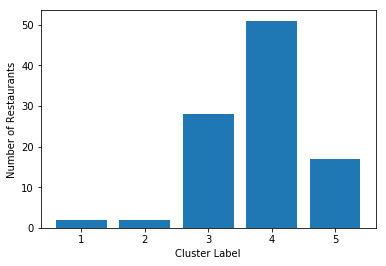

In [197]:
x = restaurant_cluster['Cluster Label']
y = restaurant_cluster['Venue']
plt.bar(x,y)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Restaurants")
plt.show()

## 11. Observation :-
### Most of the restaurants are concentrated around the area of Bronx, Manhattan and Statan Island of New York with highest in number in cluster 4 and moderately present in cluster 3 and cluster 5. Cluster 1 and cluster 2 have very less number of restaurants but there are many unfavourable elements like farms, factories etc. present their which can harm the profits produced by a restaurant. Cluster 6 and cluster 7 has no restaurants in them as they are packed with construction sites and industries that's why it is very unlikely to open a new restaurant there. The best areas for opening a new restaurant are in cluster 3, cluster 4, and cluster 5. However due to presence of a large number of restaurants in cluster 3 and cluster 4, opening a restaurant there will be very competitive. In cluster 1 and cluster 2 there are some restaurants doing well but there are unfavourable conditions also present and most of the good locations must be already taken or will be available at a very high cost. Therefore this project recommends investors to open a new restaurant in areas of cluster 5 with little competition and very favourable conditions. Opening restaurant in areas in cluster 4 and cluster 3 will result in immense competition but a lot of customers. Opening restaurant in areas near cluster 1 and cluster 2 will result in less customers and neglegible competition.

<img src="https://i2.wp.com/ijgolding.com/admin/wp-content/uploads/2014/08/0-thank-you1.jpg">